In [503]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

from libs.useful_functions import clean_text
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})


import numpy as np

import matplotlib
import matplotlib.pyplot as plt
# new_style = {'grid': False}
# matplotlib.rc('axes', **new_style)
matplotlib.rcParams['grid.color'] = '#53868B'
matplotlib.rcParams['grid.linewidth'] = 0
matplotlib.rcParams['axes.facecolor'] = '#53868B'
matplotlib.rcParams['lines.linewidth'] = 3
plt.style.use('seaborn-colorblind')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set3.colors)
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16


from scipy.sparse import csr_matrix
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
from sklearn.metrics.pairwise import rbf_kernel, pairwise_kernels
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

import keras
from keras.models import Model

In [504]:
import pysparnn.cluster_index as ci

In [3]:
path = r'D:/Projects/data/'

# <b style = "color:orange;font-size:50px">MAIN IDEA</b>

# <b style = "color:orange;font-size:30px">Build a model that takes user statistics and decides whether this user is a fraudster</b>

# <b style = "color:blue;font-size:30px">STEP 1: Check each data source separately</b>

# Ideas to check

<div class="alert alert-block alert-warning">
<ul><b>
    <li style="font-size:20px">fraudulent users have lots of streams</li>
    <li style="font-size:20px">fraudulent users have lots of tracks</li>
    <li style="font-size:20px">fraudulent users have close to 0 gap between streams</li>
    <li style="font-size:20px">fraudulent users have long streams</li>
    </b>
</ul>
</div>

# Users

In [4]:
users = pd.read_csv(path + 'users', compression = 'gzip', header = None)
users.columns = ['access', 'birth_year', 'country', 'gender', 'user_id']
users['user_id'] = users['user_id'].map(lambda x: x.split(':')[1].replace("{", "").replace("}", "").strip('"'))
users.head()

,access,birth_year,country,gender,user_id
0,"{""access"":""free""","birth_year:""1989""",country:8,"gender:""female""",093449f2282b4e4793948bbc3e9f1fd7278c0c49
1,"{""access"":""premium""","birth_year:""2001""",country:4,"gender:""female""",3e9603e5ab69c5cfe14dcc1954c46cd849940b24
2,"{""access"":""premium""","birth_year:""1988""",country:52,"gender:""female""",c12f6f2784787619d91f61cf215480b70d47f36e
3,"{""access"":""premium""","birth_year:""1995""",country:16,"gender:""female""",d55e6dc8e7fdd87d42b639ed27ca95795738308b
4,"{""access"":""premium""","birth_year:""1996""",country:44,"gender:""female""",6b1867e55d95cd39f0b3eac38518fd11572e732f


In [5]:
users.shape

(1787756, 5)

In [6]:
users.shape[0] == users['user_id'].nunique()

True

In [7]:
users.nunique()

access              3
birth_year        146
country            61
gender              3
user_id       1787756
dtype: int64

### Access

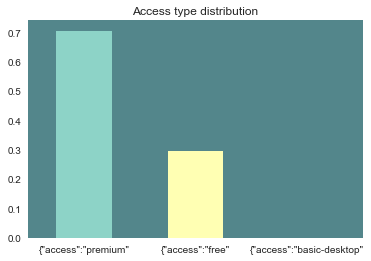

In [8]:
plt.title('Access type distribution')
(users['access'].value_counts() / users.shape[0]).plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.show()

### Gender

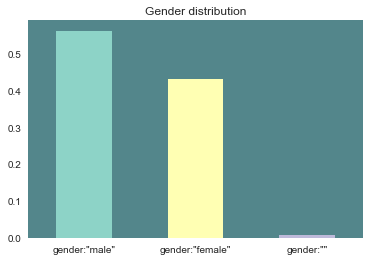

In [9]:
plt.title('Gender distribution')
(users['gender'].value_counts() / users.shape[0]).plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.show()

### Country

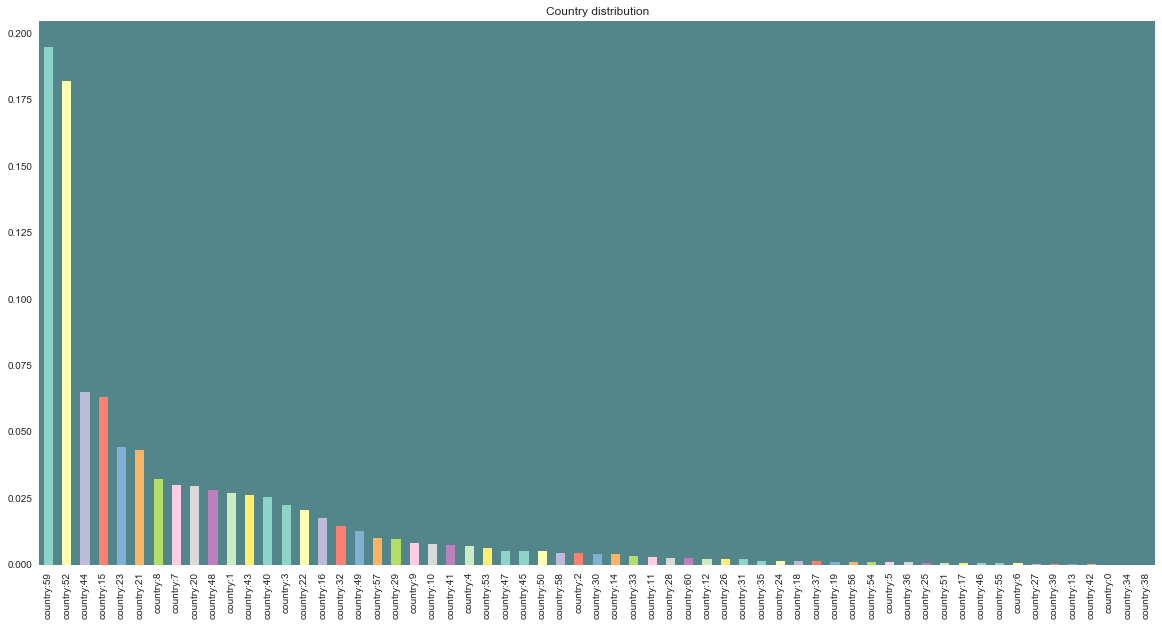

In [10]:
plt.title('Country distribution')
(users['country'].value_counts() / users.shape[0]).plot(kind = 'bar', figsize  = (20, 10))
plt.xticks(rotation = 90)
plt.show()

In [11]:
users[users['country'].isin(users['country'].value_counts().index[:4])].shape[0] / users.shape[0], \
users['country'].value_counts().index[:4].tolist()

(0.505024734919083, ['country:59', 'country:52', 'country:44', 'country:15'])

In [12]:
top_countries = users['country'].value_counts().index[:4].tolist()

### Age

In [13]:
users['birth_year'] = users['birth_year'].map(lambda x: clean_text(x , 'numbers')).replace('', '2000').astype(int)

In [14]:
users['age'] = 2018 - users['birth_year']

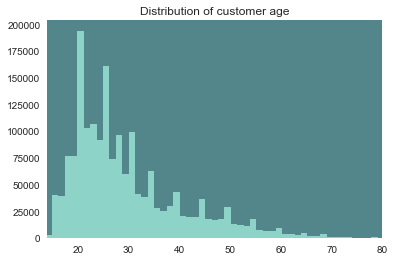

In [15]:
plt.title('Distribution of customer age')
ax = users['age'].hist(bins = 100)
ax.set_xlim(14, 80)
plt.show()

### Age and gender

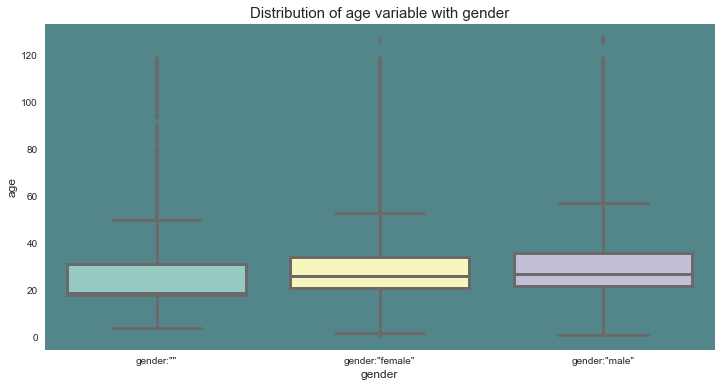

In [16]:
x_name = 'gender'
y_name = 'age'
col_order = np.sort(users[x_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=x_name, y=y_name, data=users, order=col_order)
plt.xlabel(x_name, fontsize=12)
plt.ylabel(y_name, fontsize=12)
plt.title("Distribution of %s variable with %s" % (y_name, x_name), fontsize=15)
plt.show()

### Age and access type

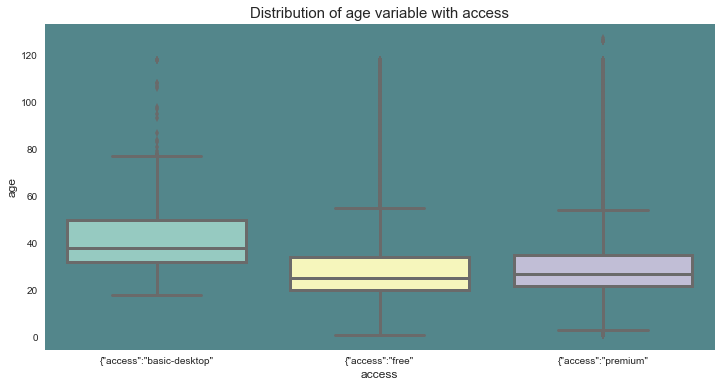

In [17]:
x_name = 'access'
y_name = 'age'
col_order = np.sort(users[x_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=x_name, y=y_name, data=users, order=col_order)
plt.xlabel(x_name, fontsize=12)
plt.ylabel(y_name, fontsize=12)
plt.title("Distribution of %s variable with %s" % (y_name, x_name), fontsize=15)
plt.show()

### Age and country

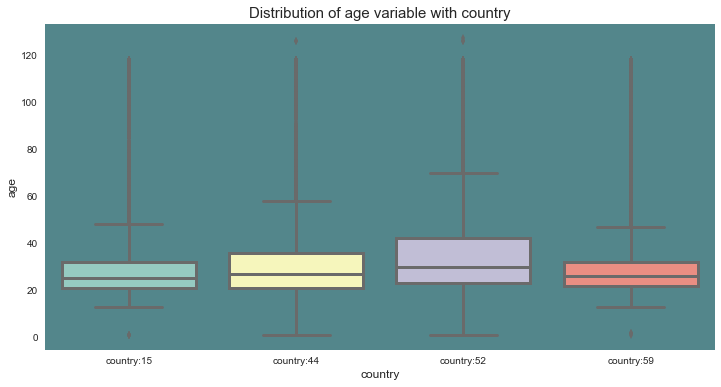

In [18]:
x_name = 'country'
y_name = 'age'
col_order = np.sort(top_countries).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=x_name, y=y_name, data=users[users['country'].isin(top_countries)], order=col_order)
plt.xlabel(x_name, fontsize=12)
plt.ylabel(y_name, fontsize=12)
plt.title("Distribution of %s variable with %s" % (y_name, x_name), fontsize=15)
plt.show()

# Tracks

In [19]:
import gzip
import json

tracks=gzip.open(path + 'tracks','rb')
tracks=tracks.read().decode().split('\n')

strings = []

counter = 0
for track in tracks:    
    line = json.loads(track)
    _ = []
    for key, value in line.items():
        _.append(key  + ' : ' + value)
    strings.append(_)

tracks = pd.DataFrame(strings)

In [20]:
# tracks = pd.read_csv(path + 'tracks', compression = 'gzip', quotechar = '"',
#                      header = None, error_bad_lines=False)
tracks.columns = ['album_artist', 'album_code', 'album_name', 'track_id', 'track_name']
tracks['track_id'] = tracks['track_id'].map(lambda x: x.split(':')[1].replace("{", "").replace("}", "").strip('"'))
tracks.head()

,album_artist,album_code,album_name,track_id,track_name
0,album_artist : Tasia Rojas,album_code : ece406c1937c4123e6b935f39898770dc...,album_name : Salmon Addition,fe2f34b55827b9721aa503d1dc9f3bca951859de,track_name : Doubtful Anteater
1,album_artist : Gertrude Faulkner,album_code : bb94c41eade59eeec79b04aa141c99344...,album_name : Newfoundland Quilt,2432c3346fc867e9026174ea73ab787a7fdeaa1f,track_name : Heartbreaking Louse
2,album_artist : Ora Corcoran,album_code : 0db473f623b01b0134f8178512f91e5ac...,album_name : Havanese Push,cb5e2409dfa5c9c8ccabdca2afeb6e84eca9a435,track_name : Watery Tortoise
3,album_artist : Shanika Wing,album_code : 4aadb443b1d8cc4c84a6ca1dd348c5993...,album_name : Puma Hate,2998e8ecabbf9d220dc22c516740f7982b2353e8,track_name : Nutritious Ox
4,album_artist : Lonnie Hope,album_code : a2b64056f39d60b0de18550d43a37b64b...,album_name : Kingfisher Garden,fb581ad122d260941757c5a2b1ed1a42108d632f,track_name : Foregoing Umbrellabird


In [21]:
tracks.shape

(83426, 5)

In [22]:
tracks.shape[0] == tracks['track_id'].nunique()

True

In [23]:
tracks.nunique()

album_artist    16915
album_code      24913
album_name      23201
track_id        83426
track_name      70979
dtype: int64

### Number of tracks per artist

Median value: 2.0


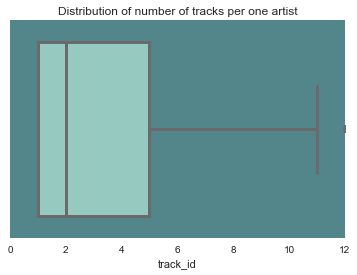

In [24]:
plt.title('Distribution of number of tracks per one artist')
print("Median value: %s" % tracks.groupby('album_artist')['track_id'].nunique().median())
ax = sns.boxplot(x=tracks.groupby('album_artist')['track_id'].nunique())
ax.set_xlim(0, 12)
plt.show()

### Number of albums per artist

Median value: 1.0


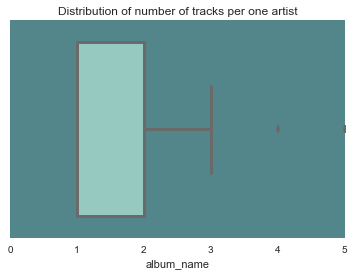

In [25]:
plt.title('Distribution of number of tracks per one artist')
print("Median value: %s" % tracks.groupby('album_artist')['album_name'].nunique().median())
ax = sns.boxplot(x=tracks.groupby('album_artist')['album_name'].nunique())
ax.set_xlim(0, 5)
plt.show()

### Number of tracks per album

Median value: 1.0


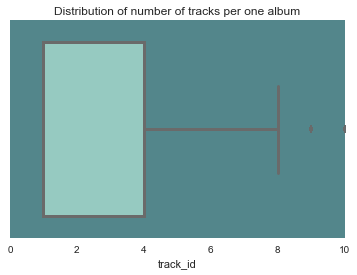

In [26]:
plt.title('Distribution of number of tracks per one album')
print("Median value: %s" % tracks.groupby('album_name')['track_id'].nunique().median())
ax = sns.boxplot(x=tracks.groupby('album_name')['track_id'].nunique())
ax.set_xlim(0, 10)
plt.show()

# Allcountries

In [27]:
allcountries = pd.read_csv(path + 'allcountries', compression = 'gzip', header = None, engine = 'python', quotechar="'", error_bad_lines=False)
allcountries.columns = ['device_type', 'length', 'os', 'timestamp', 'track_id', 'user_id']
allcountries['user_id'] = allcountries['user_id'].map(lambda x: x.split(':')[1].replace("{", "").replace("}", "").strip('"'))
allcountries['track_id'] = allcountries['track_id'].map(lambda x: x.split(':')[1].replace("{", "").replace("}", "").strip('"'))
allcountries.head()

,device_type,length,os,timestamp,track_id,user_id
0,"{""device_type"":""mobile""","""length"":136","""os"":""iOS""","""timestamp"":1504923300000",c43ac11b86c603e40aad9a0fbe72d192c0c51ded,3db57275059923d98119850a6233d3c609a171a5
1,"{""device_type"":""desktop""","""length"":60","""os"":""Browser""","""timestamp"":1504951200000",eee087bddc7db49cde2d43df7a04f3975dff4a78,0495eb11e3ca80c0289d3a08b5c60f0227e12314
2,"{""device_type"":""mobile""","""length"":191","""os"":""iOS""","""timestamp"":1504944900000",45e8fe7c02519b99b9284717cd3488eab2ef798e,b3d9fb538674878162e5a93566195daf878723db
3,"{""device_type"":""desktop""","""length"":268","""os"":""other""","""timestamp"":1504980900000",eb1016ee12dc5a3ada044b7dacb716049ed121c8,4831658d8f436e8c6ecf29984c405521de26e654
4,"{""device_type"":""mobile""","""length"":212","""os"":""Android""","""timestamp"":1504916100000",863af142e7604488cfd8f2245b65c9e6cafcd201,e1a1bb65848f54f266273caad9a327d13397889f


In [28]:
allcountries.shape

(4313582, 6)

In [29]:
allcountries.shape[0] == allcountries['track_id'].nunique(), allcountries.shape[0] == allcountries['user_id'].nunique()

(False, False)

In [30]:
allcountries.nunique()

device_type          3
length             870
os                   8
timestamp           96
track_id         83426
user_id        1787756
dtype: int64

### Number of tracks per user

Median value: 1.0


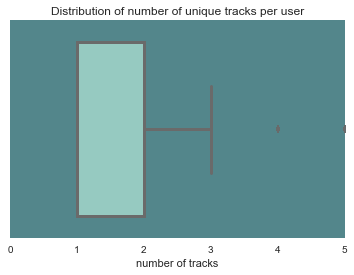

In [31]:
plt.title('Distribution of number of unique tracks per user')
user_track_unique = allcountries.groupby('user_id')['track_id'].nunique()
print("Median value: %s" % user_track_unique.median())
ax = sns.boxplot(x=user_track_unique)
ax.set_xlim(0, 5)
plt.xlabel('number of tracks')
plt.show()

#### Check if we have some suspicious outliers (extreme number of unique tracks)

In [32]:
user_track_unique.describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99, .999])

count   1,787,756.00
mean            1.77
std             4.11
min             1.00
1%              1.00
10%             1.00
20%             1.00
30%             1.00
40%             1.00
50%             1.00
60%             1.00
70%             1.00
80%             2.00
90%             3.00
99%            11.00
99.9%          36.00
max           593.00
Name: track_id, dtype: float64

#### Check how many users with tracks more than 3

In [33]:
print("There are only %s users with number of tracks more than 3" % user_track_unique[user_track_unique > 3].shape[0])

There are only 136384 users with number of tracks more than 3


#### Save statistics

In [34]:
user_track_unique = user_track_unique[user_track_unique > 3]

### Streams by OS

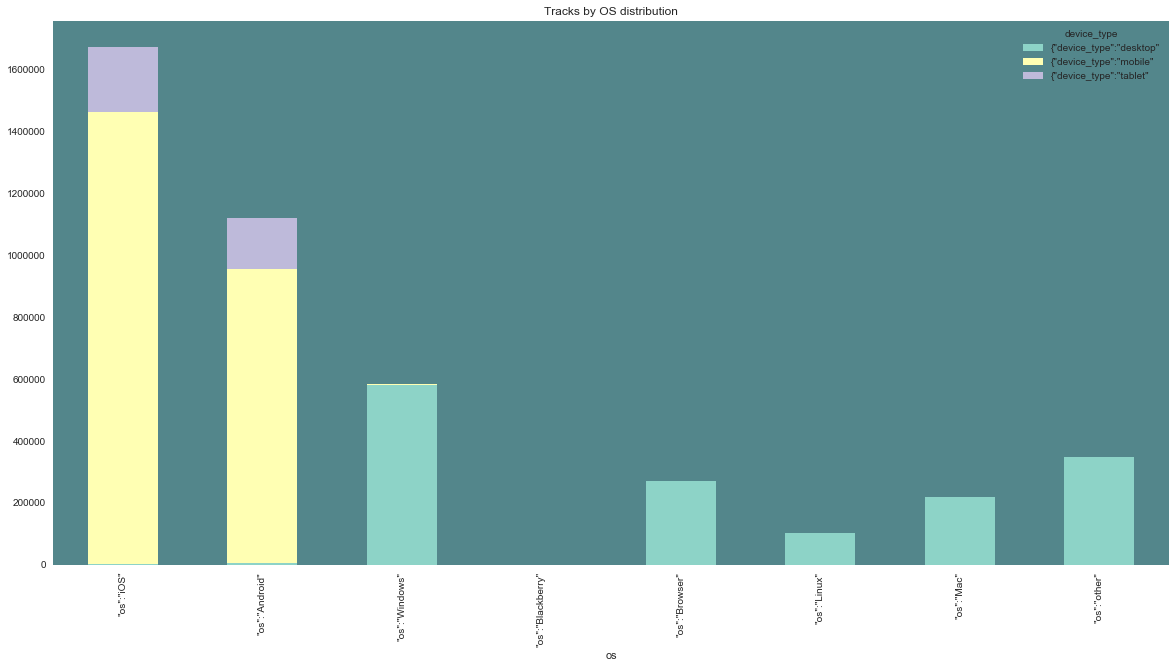

In [35]:
s = allcountries.groupby(['os', 'device_type']).size().reset_index().pivot(columns='device_type', index='os', values=0).fillna(0)
s.sort_values(by = ['{"device_type":"mobile"'], ascending = False).plot(kind='bar', stacked=True, figsize = (20, 10))
plt.title('Tracks by OS distribution')
plt.xticks(rotation = 90)
plt.show()

### Users by OS

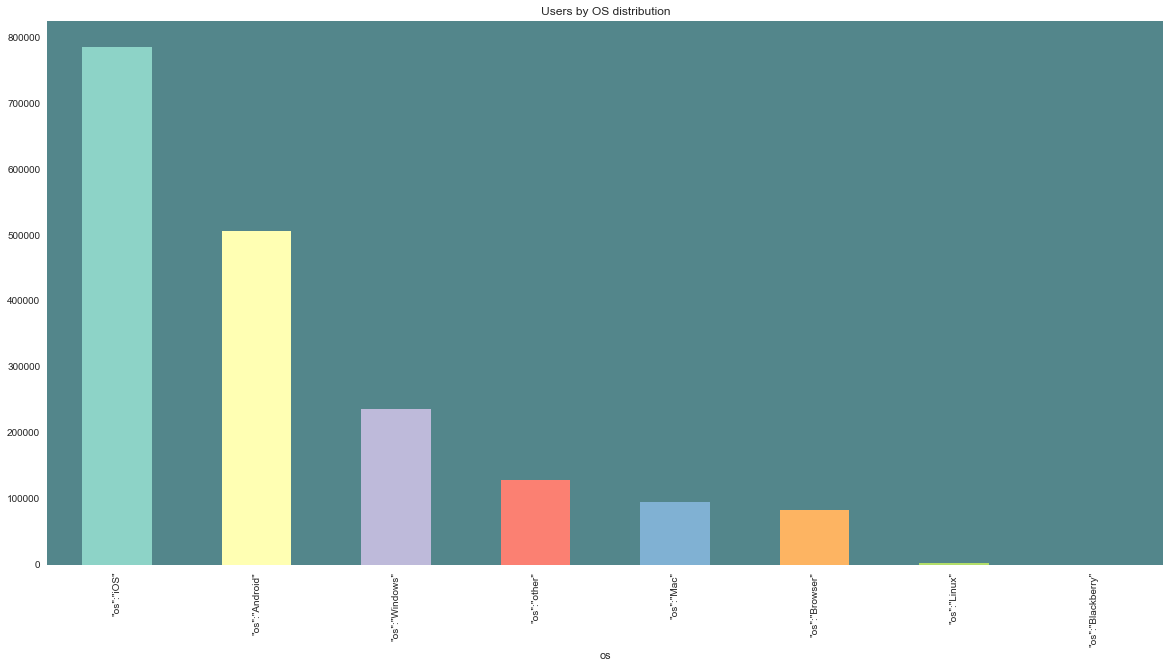

In [36]:
plt.title('Users by OS distribution')
allcountries.groupby('os')['user_id'].nunique().sort_values(ascending = False).plot(kind = 'bar', figsize  = (20, 10))
plt.xticks(rotation = 90)
plt.show()

### Tracks by OS

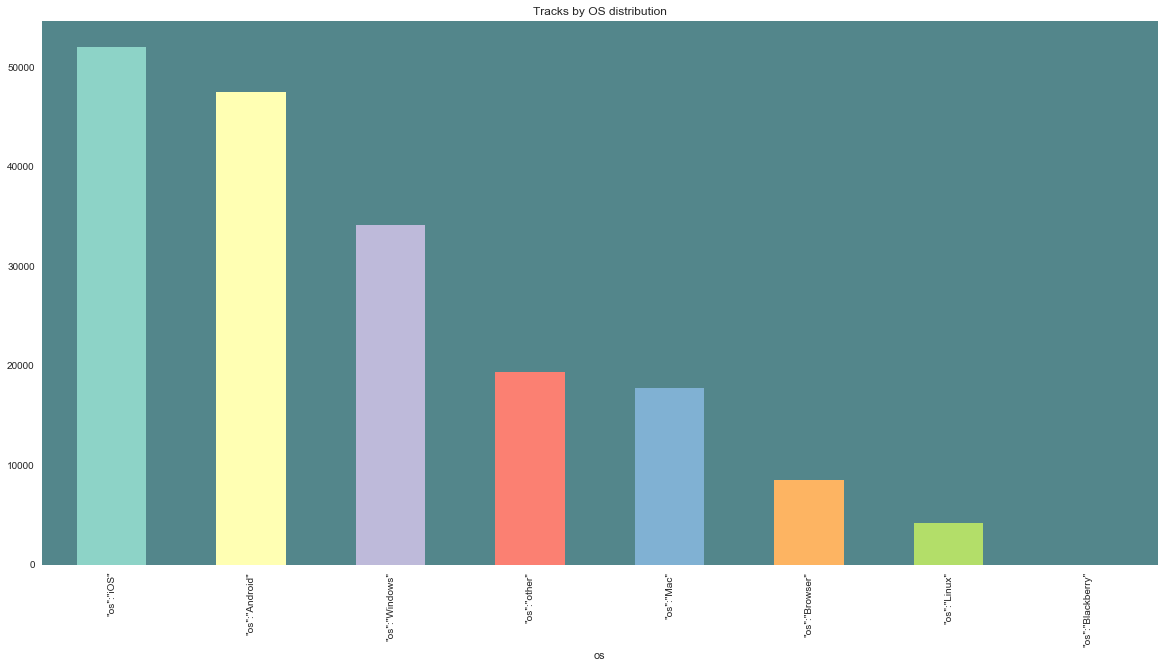

In [37]:
plt.title('Tracks by OS distribution')
allcountries.groupby('os')['track_id'].nunique().sort_values(ascending = False).plot(kind = 'bar', figsize  = (20, 10))
plt.xticks(rotation = 90)
plt.show()

### Distribution of streams per user

Median value: device_type
{"device_type":"desktop"   160,566.50
{"device_type":"mobile"          0.50
{"device_type":"tablet"          0.00
dtype: float64


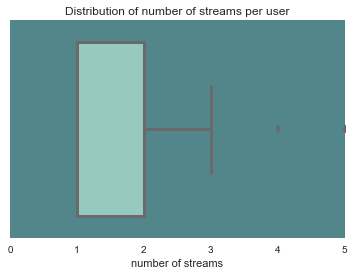

In [38]:
plt.title('Distribution of number of streams per user')
user_track_count = allcountries.groupby('user_id')['track_id'].count()
print("Median value: %s" % s.median())
ax = sns.boxplot(x=user_track_count)
ax.set_xlim(0, 5)
plt.xlabel('number of streams')
plt.show()

#### Check if we have some suspicious outliers (extreme number of streams)

In [39]:
user_track_count.describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99, .999])

count   1,787,756.00
mean            2.41
std            13.47
min             1.00
1%              1.00
10%             1.00
20%             1.00
30%             1.00
40%             1.00
50%             1.00
60%             1.00
70%             2.00
80%             2.00
90%             4.00
99%            16.00
99.9%          86.00
max         3,310.00
Name: track_id, dtype: float64

#### Check how many users with streams more than 4

In [40]:
print("There are only %s users with number of streams more than 100" % user_track_count[user_track_count > 4].shape[0])

There are only 148821 users with number of streams more than 100


#### Save statistics for further analysis

In [41]:
user_track_count = user_track_count[user_track_count > 4]

### Distribution of stream length

In [42]:
allcountries['length'] = allcountries['length'].map(lambda x: clean_text(x , 'numbers')).astype(int)

Median value: 172.0


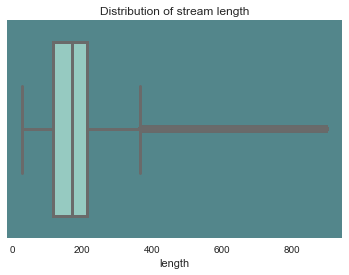

In [43]:
plt.title('Distribution of stream length')
print("Median value: %s" % allcountries['length'].median())
ax = sns.boxplot(x=allcountries['length'])
# ax.set_xlim(0, 10)
plt.show()

#### Check if we have some suspicious outliers (extreme length of streams)

In [44]:
allcountries['length'].describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99, .999])

count   4,313,582.00
mean          172.80
std            88.65
min            30.00
1%             32.00
10%            60.00
20%            96.00
30%           136.00
40%           157.00
50%           172.00
60%           189.00
70%           206.00
80%           229.00
90%           262.00
99%           482.00
99.9%         733.00
max           900.00
Name: length, dtype: float64

#### Check how many users have length of streams more than 300

In [45]:
user_stream_length = allcountries.groupby('user_id')['length'].max()

In [46]:
print("There are only %s users with max length of streams more then 800" % user_stream_length[user_stream_length > 300].shape[0])

There are only 132322 users with max length of streams more then 800


#### Save statistics

In [47]:
user_stream_length = user_stream_length[user_stream_length > 300]

### DIstribution of number of devices per user

Median value: 1.0


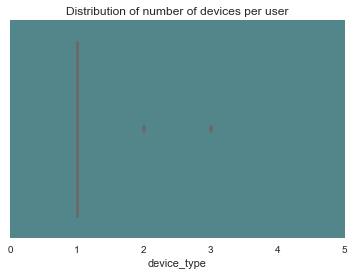

In [48]:
plt.title('Distribution of number of devices per user')
s = allcountries.groupby('user_id')['device_type'].nunique()
print("Median value: %s" % s.median())
ax = sns.boxplot(x=s)
ax.set_xlim(0, 5)
plt.show()

### Distribution of track length for different OS

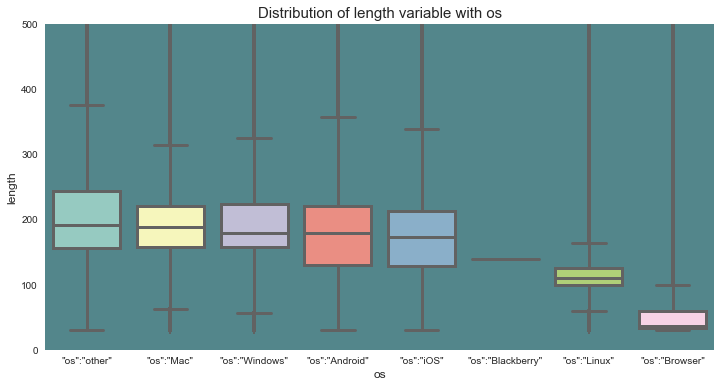

In [49]:
x_name = 'os'
y_name = 'length'
col_order = allcountries.groupby(x_name)[y_name].mean().sort_values(ascending = False).index.tolist()
plt.figure(figsize=(12,6))
ax = sns.boxplot(x=x_name, y=y_name, data=allcountries, order=col_order)
plt.xlabel(x_name, fontsize=12)
plt.ylabel(y_name, fontsize=12)
plt.title("Distribution of %s variable with %s" % (y_name, x_name), fontsize=15)
ax.set_ylim(0, 500)
plt.show()

### Distribution of track length for different device types

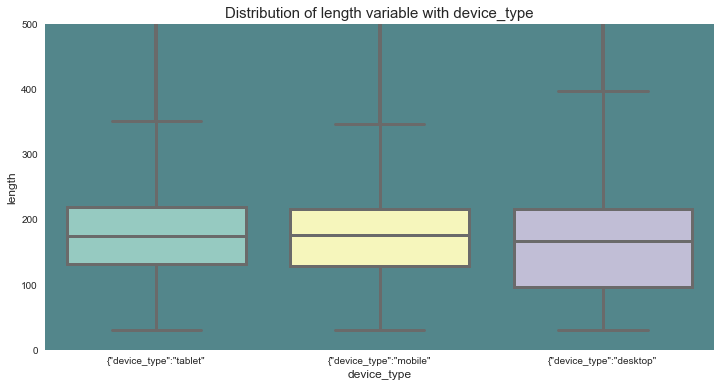

In [50]:
x_name = 'device_type'
y_name = 'length'
col_order = allcountries.groupby(x_name)[y_name].mean().sort_values(ascending = False).index.tolist()
plt.figure(figsize=(12,6))
ax = sns.boxplot(x=x_name, y=y_name, data=allcountries, order=col_order)
plt.xlabel(x_name, fontsize=12)
plt.ylabel(y_name, fontsize=12)
plt.title("Distribution of %s variable with %s" % (y_name, x_name), fontsize=15)
ax.set_ylim(0, 500)
plt.show()

### Distribution of gap between streams for users

In [51]:
allcountries = allcountries.sort_values(by = ['user_id', 'timestamp'])

allcountries['timestamp'] = allcountries['timestamp'].map(lambda x: clean_text(x , 'numbers')[:10]).astype(int)
allcountries['timestamp_previous'] = allcountries.groupby('user_id', sort = False)['timestamp'].shift(1)

# allcountries['timestamp'] = pd.to_datetime(allcountries['timestamp'],unit='s')
# allcountries['timestamp_previous'] = pd.to_datetime(allcountries['timestamp_previous'],unit='s')

allcountries['gap'] = allcountries['timestamp'] - allcountries['timestamp_previous']

# convert gaps to minutes units
allcountries['gap'] = allcountries['gap'] / (60)

In [52]:
allcountries[allcountries['gap'].notnull()]['gap'].describe()

count   2,525,826.00
mean           79.58
std           173.72
min             0.00
25%             0.00
50%            15.00
75%            60.00
max         1,425.00
Name: gap, dtype: float64

Median value: 15 minutes


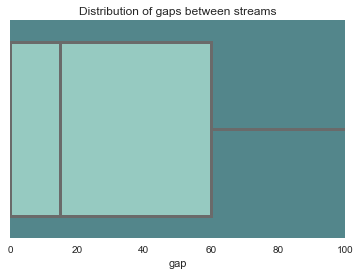

In [53]:
plt.title('Distribution of gaps between streams')
user_gap_stat = allcountries[allcountries['gap'].notnull()]['gap']
print("Median value: %s minutes" % int(user_gap_stat.median()))
ax = sns.boxplot(x=user_gap_stat)
ax.set_xlim(0, 100)
plt.show()

In [54]:
user_gap_stat.describe([.01,.1,.2,.3,.4,.45, .5,.6,.7,.8,.9,.99, .999])

count   2,525,826.00
mean           79.58
std           173.72
min             0.00
1%              0.00
10%             0.00
20%             0.00
30%             0.00
40%             0.00
45%            15.00
50%            15.00
60%            15.00
70%            45.00
80%           105.00
90%           240.00
99%           915.00
99.9%       1,290.00
max         1,425.00
Name: gap, dtype: float64

#### Check for users who have 0 median gap between streams

In [55]:
user_gap_stat = allcountries[allcountries['gap'].notnull()].groupby('user_id')['gap'].median()

In [56]:
print("There are only %s users with median gap between streams equal 0" % user_gap_stat[user_gap_stat == 0].shape[0])

There are only 118947 users with median gap between streams equal 0


#### Save statistics

In [57]:
user_gap_stat = user_gap_stat[user_gap_stat == 0]

### Dependency between stream length and gap between streams

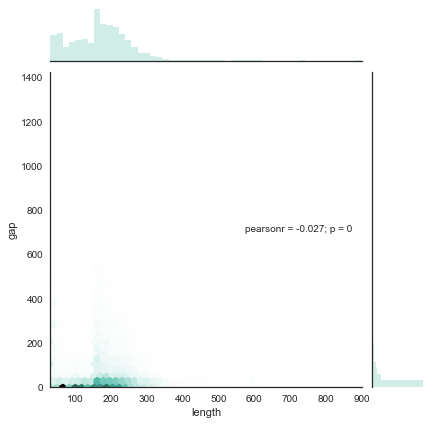

In [58]:
with sns.axes_style('white'):
    sns.jointplot("length", "gap", allcountries, kind='hex')

### Dependency between stream length and number of streams

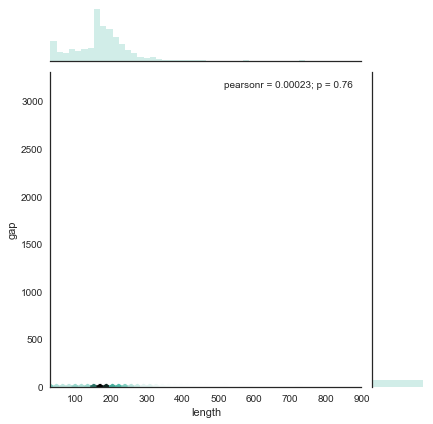

In [59]:
s  = allcountries.groupby('user_id')["length", "gap"].agg({'length' : 'mean', 'gap' : 'count'}).reset_index()
with sns.axes_style('white'):
    sns.jointplot("length", "gap", s, kind='hex')

# Fast check if users with huge number of streams are the same as users with small gap between streams and huge length of streams

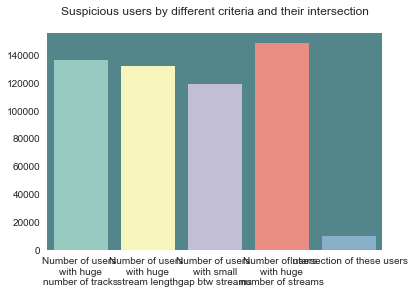

In [60]:
plt.title('Suspicious users by different criteria and their intersection\n')
ax = sns.barplot(['Number of users \nwith huge\nnumber of tracks',
                   'Number of users \nwith huge\nstream length',
                  'Number of users \nwith small\ngap btw streams',
                  'Number of users \nwith huge\nnumber of streams',
                 'Intersection of these users'], 
                 [user_track_unique.shape[0], user_stream_length.shape[0], user_gap_stat.shape[0], user_track_count.shape[0], 
                  len(set(user_track_unique.index) & set(user_stream_length.index) & set(user_gap_stat.index) & set(user_track_count.index))])
plt.show()

In [61]:
users_suspicious = list(set(user_track_unique.index) & set(user_stream_length.index) & set(user_gap_stat.index) & set(user_track_count.index))

In [99]:
print('Number of suspicious users: {0}'.format(len(users_suspicious)))

print('Percentage of suspicious users from total: {0:0.1f}%'.format(100*len(users_suspicious) / allcountries['user_id'].nunique()))

Number of suspicious users: 9959
Percentage of suspicious users from total: 0.6%


# Calculate statistics for users to train One-class classifier to find outliers

### Generate statistics for users

In [465]:
allusers = users[['user_id', 'gender', 'age', 'access', 'country']].copy()

allusers['gender'] = (allusers['gender'] == 'gender:"female"')*1

for i, t in enumerate(top_countries):
    allusers['top_country_' + str(i)] = (allusers['country'] == t)*1
allusers.drop(['country'], axis = 1, inplace = True)
              
for i, t in enumerate(['{"access":"free"', '{"access":"premium"']):
    allusers['access_' + str(i)] = (allusers['access'] == t)*1
allusers.drop(['access'], axis = 1, inplace = True)

allusers['user_track_unique'] = allusers['user_id'].map(allcountries.groupby('user_id')['track_id'].nunique())

allusers['user_stream_length_mean'] = allusers['user_id'].map(allcountries.groupby('user_id')['length'].mean())

allusers['user_gap_mean'] = \
allusers['user_id'].map(allcountries[allcountries['gap'].notnull()].groupby('user_id')['gap'].mean()).fillna(0)

allusers['user_track_count'] = allusers['user_id'].map(allcountries.groupby('user_id')['track_id'].count())

track_stat = allcountries['track_id'].value_counts().reset_index()
track_stat.columns = ['track_id', 'total_count']
user_track = allcountries.groupby(['user_id', 'track_id'])['device_type'].count().reset_index()\
.rename(columns = {'device_type' : 'user_count'})
user_track = pd.merge(user_track, track_stat, how = 'inner', on = 'track_id')

user_track['user_share'] = user_track['user_count'] / user_track['total_count']

allusers['user_track_mean_share'] = allusers['user_id'].map(user_track.groupby('user_id')['user_share'].mean())

In [466]:
mean_dict = {}
std_dict = {}

for col in allusers.columns[9:]:
    mean = allusers[col].mean()
    std = allusers[col].std()
    allusers[col] = (allusers[col] - mean) / std
    mean_dict[col] = mean
    std_dict[col] = std
    print(col)

user_track_unique
user_stream_length_mean
user_gap_mean
user_track_count
user_track_mean_share


In [467]:
allusers.tail()

,user_id,gender,age,top_country_0,top_country_1,top_country_2,top_country_3,access_0,access_1,user_track_unique,user_stream_length_mean,user_gap_mean,user_track_count,user_track_mean_share
1787751,fb8315fb3385f0ee6ba6fc7437c9af002ed362c6,0,27,0,0,0,0,1,0,0.06,1.44,-0.37,-0.03,-0.18
1787752,fc1f98c253c5556773f3632b1f4ec2e2d14b793b,1,21,0,0,0,0,1,0,-0.19,-1.50,-0.37,-0.10,-0.19
1787753,8988962c5ac51633a27ed89a9b7f26a342cd594a,0,28,0,0,0,0,1,0,-0.19,-1.75,-0.37,-0.10,-0.15
1787754,01145c552ba2baf0cd3fd7697410eda8fee920a1,1,32,0,1,0,0,0,1,0.06,-1.13,-0.37,-0.03,0.02
1787755,d709f727c9d1b8d6fa90991fd412017bdd0786c8,1,19,0,0,0,0,0,1,-0.19,0.09,-0.37,-0.10,-0.18


In [468]:
from sklearn.ensemble import IsolationForest

In [469]:
clf = IsolationForest(contamination=0.3, n_jobs = -1, random_state = 0, max_features = allusers.iloc[:, 1:].shape[1])
clf.fit(allusers.iloc[:, 1:])

IsolationForest(bootstrap=False, contamination=0.3, max_features=13,
        max_samples='auto', n_estimators=100, n_jobs=-1, random_state=0,
        verbose=0)

In [470]:
allusers['outlier'] = (clf.predict(allusers.iloc[:, 1:]) == -1)*1

#### It is important that outliers have suspicious number of tracks

In [471]:
allusers['outlier'] = ((abs(allusers['user_track_unique']) > 2) & \
                       (abs(allusers['user_track_count']) > 2) & (allusers['outlier'] == 1))*1

In [472]:
allusers['outlier'].value_counts()

0    1782915
1       4841
Name: outlier, dtype: int64

In [473]:
print('Intersection with manually detected fraudsters: ', \
    len(set(allusers[allusers['outlier'] == 1]['user_id'].values) & set(users_suspicious)) / len(users_suspicious))

Intersection with manually detected fraudsters:  0.14931217993774476


In [474]:
allusers[allusers['outlier'] == 1].head(10)

,user_id,gender,age,top_country_0,top_country_1,top_country_2,top_country_3,access_0,access_1,user_track_unique,user_stream_length_mean,user_gap_mean,user_track_count,user_track_mean_share,outlier
502,7d486e1321f8f4d0bba841c934fc9ab4629d26ce,0,28,0,1,0,0,0,1,4.19,0.04,-0.28,2.05,0.01,1
593,524a149eeda0eefa1bf4165f8c33a0213ef1681a,1,51,0,0,0,0,0,1,6.87,-0.50,-0.37,2.12,-0.18,1
2202,3829699e1a7369115fbd920e257d3ce4f6b4dd9d,0,53,0,1,0,0,0,1,5.65,0.12,-0.24,2.64,0.04,1
2850,ed136c02c74c5fac95ab4ea3661d749b8f2170fc,0,41,0,1,0,0,1,0,2.25,-1.42,-0.22,3.09,0.02,1
2902,e52172b0ad5ccf6232306c3dc7992ec151cd5543,1,27,0,0,0,0,1,0,55.51,-0.85,-0.36,136.42,0.11,1
3066,e4855cf0abda616c15423c6b46a5f6eab5b602d5,0,22,0,0,1,0,0,1,4.43,0.31,-0.37,2.79,-0.14,1
3604,44ac8d3c188beb43a79d8517e36429b6c6eabfab,0,24,0,0,0,0,0,1,8.08,-0.62,-0.22,2.57,-0.07,1
3657,431602c95cec1267fbf8797a86faaf231f6167b7,0,37,1,0,0,0,0,1,51.62,-0.01,-0.33,19.35,-0.06,1
4028,054907f2b6ba119eae515cdaa8ddcc6884e38906,0,51,1,0,0,0,0,1,11.00,-0.46,-0.31,4.57,-0.17,1
4138,fcc132e62ff14bf9413a5f3fb41d806fdd29ba83,0,58,1,0,0,0,1,0,7.35,0.53,-0.34,22.69,4.30,1


#### possible number of outliers at step 1

In [475]:
print('Number of suspicious users: {0}'.format(allusers['outlier'].sum()))

print('Percentage of suspicious users from total: {0:0.1f}%'.format(100*allusers['outlier'].sum() / allcountries['user_id'].nunique()))

Number of suspicious users: 4841
Percentage of suspicious users from total: 0.3%


# Step 1 conclusions:

<div class="alert alert-block alert-warning">
<ul><b>
    <li style="font-size:20px">There are users with huge number of tracks</li>
    <li style="font-size:20px">There are users with huge number of streams</li>
    <li style="font-size:20px">There are users with huge length of streams</li>
    <li style="font-size:20px">There are users with 0 median gap between streams</li>
    <li style="font-size:20px">There are 6523 users that are suspiciously active</li>
    </b>
</ul>
</div>

# <b style = "color:blue;font-size:30px">STEP 2: Track history</b>

<div class="alert alert-block alert-warning">
<ul><b>
    <li style="font-size:20px">fraudulent users could have multiple accounts</li>
    </b>
</ul>
</div>

# Check if suspicious users have similar track history

In [100]:
user_track_s = allcountries[allcountries['user_id'].isin(users_suspicious)].groupby(['user_id', 'track_id'])['device_type'].count()\
.reset_index().rename(columns = {'device_type' : 'count'})

user_track_ns = allcountries[~allcountries['user_id'].isin(users_suspicious)].sample(frac = 0.02).groupby(['user_id', 'track_id'])['device_type'].count()\
.reset_index().rename(columns = {'device_type' : 'count'})

user_track = pd.concat([user_track_s, user_track_ns])

users_u = list(sorted(user_track.user_id.unique()))
track_u = list(sorted(user_track.track_id.unique()))

data = user_track['count'].tolist()
row = user_track.user_id.astype('category', categories=users_u).cat.codes
col = user_track.track_id.astype('category', categories=track_u).cat.codes
sparse_matrix = csr_matrix((data, (row, col)), shape=(len(users_u), len(track_u)))

In [101]:
sparse_matrix.shape

(80966, 32826)

In [102]:
svd = TruncatedSVD(n_components=30, n_iter=7, random_state=42)
svd.fit(sparse_matrix)  

print('Total explained variance: ', svd.explained_variance_ratio_.sum())  

Total explained variance:  0.5536387104843593


In [103]:
tsne = TSNE(n_components=2, random_state=0, perplexity=20)

X_2d = TSNE(n_jobs=12).fit_transform(svd.transform(sparse_matrix))

tsne_df  = pd.DataFrame({'TSNE component 1' : X_2d[:, 0], 'TSNE component 2' : X_2d[:, 1], 'user_id' : users_u})
tsne_df['suspicious'] = tsne_df['user_id'].isin(users_suspicious)*1

tsne_df['suspicious'] = tsne_df['suspicious'].map({0 : 'not suspicious', 1 : 'suspicious'})

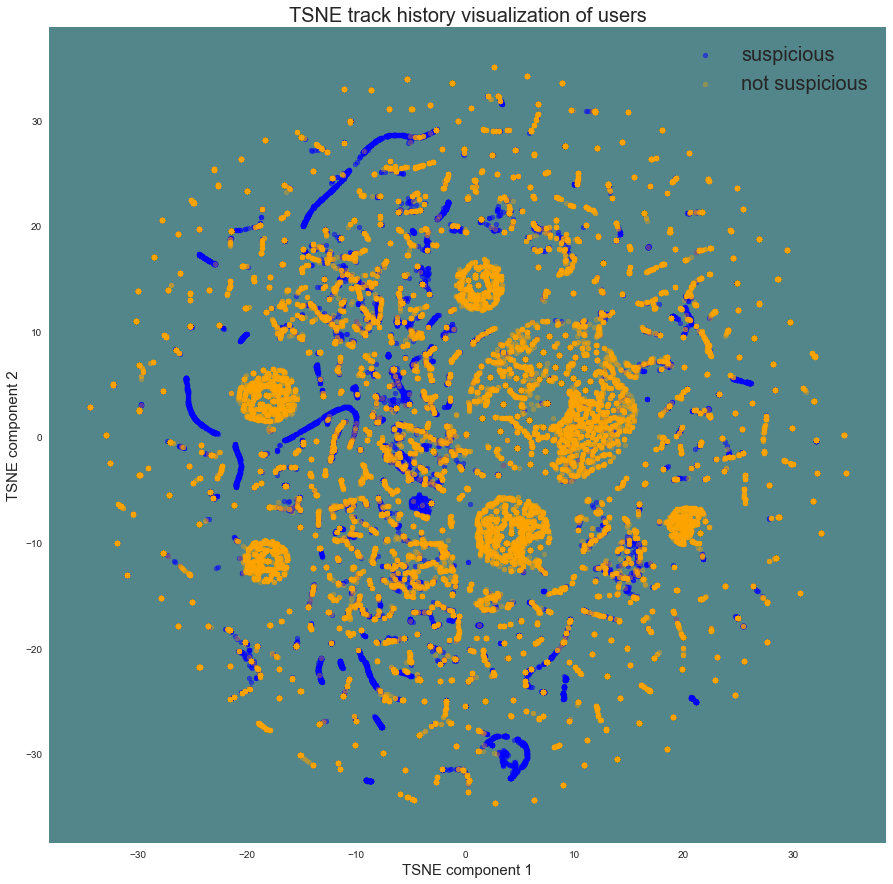

In [104]:
#Now we jsut plot a scatter plot
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('TSNE component 1', fontsize = 15)
ax.set_ylabel('TSNE component 2', fontsize = 15)
ax.set_title('TSNE track history visualization of users', fontsize = 20)

targets = ['suspicious', 'not suspicious']
colors = ['b', 'orange']
for target, color, alpha in zip(targets,colors, [0.25, 0.1]):

    indicesToKeep = tsne_df['suspicious'] == target

    ax.scatter(tsne_df.loc[indicesToKeep, 'TSNE component 1']
               , tsne_df.loc[indicesToKeep, 'TSNE component 2']
               , c = color
               , s = 25,alpha=0.25 + alpha)

ax.legend(targets, fontsize = 20)
ax.grid()

plt.show()

#### we see that many fraudsters are concentrated in the center which means they promote some specific tracks

# Fraudsters could try to promote rare tracks that have little number of streams by other users

In [105]:
track_stat = allcountries['track_id'].value_counts().reset_index()
track_stat.columns = ['track_id', 'total_count']
user_track = allcountries.groupby(['user_id', 'track_id'])['device_type'].count().reset_index()\
.rename(columns = {'device_type' : 'user_count'})
user_track = pd.merge(user_track, track_stat, how = 'inner', on = 'track_id')

Median value: 3


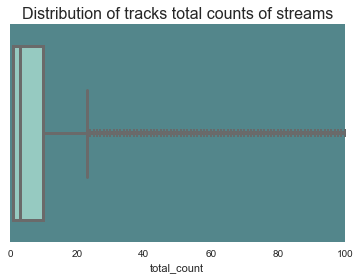

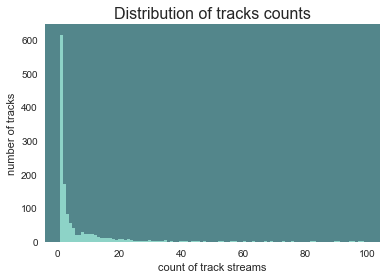

In [106]:
plt.title('Distribution of tracks total counts of streams', fontsize = 16)
print("Median value: %s" % int(track_stat['total_count'].median()))
ax = sns.boxplot(x=track_stat['total_count'])
ax.set_xlim(0, 100)
plt.show()

plt.title('Distribution of tracks counts', fontsize = 16)
t = track_stat.groupby('total_count')['track_id'].nunique()
t[t < 100].hist(bins = 100)
plt.xlabel('count of track streams')
plt.ylabel('number of tracks')
plt.show()

#### Users tend to listen different tracks but some of them listen only few

In [107]:
user_track['suspicious'] = user_track['user_id'].isin(users_suspicious)*1
user_track['user_share'] = user_track['user_count'] / user_track['total_count']

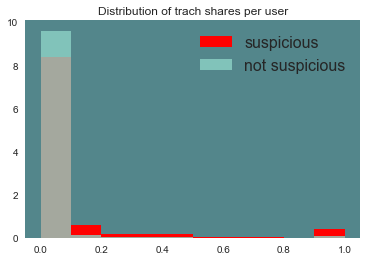

In [108]:
plt.title('Distribution of trach shares per user')
user_track[user_track['suspicious'] == 1]['user_share'].hist(label = 'suspicious', normed = True, color = 'red')
user_track[user_track['suspicious'] == 0]['user_share'].hist(label = 'not suspicious', normed = True, alpha = 0.8)
plt.legend(loc = 'upper right', fontsize = 16)
plt.show()

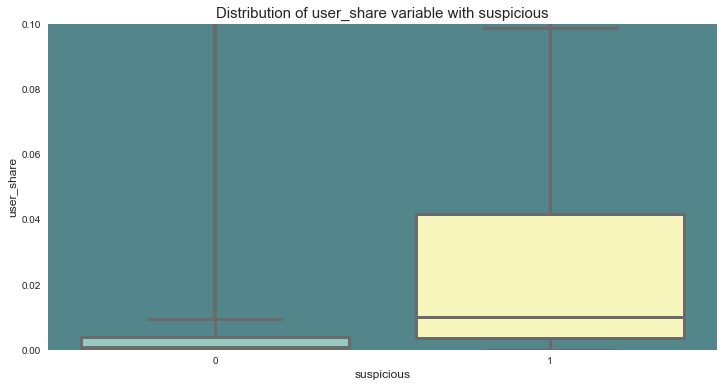

In [109]:
x_name = 'suspicious'
y_name = 'user_share'
col_order = np.sort(user_track[x_name].unique()).tolist()
plt.figure(figsize=(12,6))
ax= sns.boxplot(x=x_name, y=y_name, data=user_track, order=col_order)
ax.set_ylim(0, 0.1)
plt.xlabel(x_name, fontsize=12)
plt.ylabel(y_name, fontsize=12)
plt.title("Distribution of %s variable with %s" % (y_name, x_name), fontsize=15)
plt.show()

# For each user we receive track embeddings

### Deep learning for user emdeddings

In [110]:
user_track.head()

,user_id,track_id,user_count,total_count,suspicious,user_share
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,45e8fe7c02519b99b9284717cd3488eab2ef798e,1,117535,0,0.00
1,0000cfa27c54f3a9c1bca6ec656a52926c52d234,45e8fe7c02519b99b9284717cd3488eab2ef798e,1,117535,0,0.00
2,00012873b0a82e81b3155431769fa5ac0a8ac267,45e8fe7c02519b99b9284717cd3488eab2ef798e,1,117535,0,0.00
3,000134b94b87f70dc30597aa19598fbeaa70dc7f,45e8fe7c02519b99b9284717cd3488eab2ef798e,1,117535,0,0.00
4,00015babedef955867a39cd602388fe44b3d4362,45e8fe7c02519b99b9284717cd3488eab2ef798e,1,117535,0,0.00


In [111]:
def label_dict(series):
    counter = 0
    dicty = {}
    dicty_back = {}
    for uniq in series.unique():
        dicty[uniq] = counter
        dicty_back[counter] = uniq
        counter += 1
    return dicty, dicty_back

In [112]:
user_dict, user_dict_back = label_dict(user_track['user_id'])
user_track['user_id'] = user_track['user_id'].map(user_dict)

In [113]:
track_dict, track_dict_back = label_dict(user_track['track_id'])
user_track['track_id'] = user_track['track_id'].map(track_dict)

In [114]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(user_track, test_size=0.2, random_state = 0)

In [115]:
train.user_id.nunique()

1514033

In [116]:
y_true = test.user_count

In [117]:
n_latent_factors_user = 8
n_latent_factors_movie = 10
n_latent_factors_mf = 3
n_users, n_movies = len(user_track.user_id.unique()), len(user_track.track_id.unique())

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding_mlp = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding-MLP')(movie_input)
movie_vec_mlp = keras.layers.Flatten(name='FlattenMovies-MLP')(movie_embedding_mlp)
movie_vec_mlp = keras.layers.Dropout(0.2)(movie_vec_mlp)

movie_embedding_mf = keras.layers.Embedding(n_movies + 1, n_latent_factors_mf, name='Movie-Embedding-MF')(movie_input)
movie_vec_mf = keras.layers.Flatten(name='FlattenMovies-MF')(movie_embedding_mf)
movie_vec_mf = keras.layers.Dropout(0.2)(movie_vec_mf)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec_mlp = keras.layers.Flatten(name='FlattenUsers-MLP')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding-MLP')(user_input))
user_vec_mlp = keras.layers.Dropout(0.2)(user_vec_mlp)

user_vec_mf = keras.layers.Flatten(name='FlattenUsers-MF')(keras.layers.Embedding(n_users + 1, n_latent_factors_mf,name='User-Embedding-MF')(user_input))
user_vec_mf = keras.layers.Dropout(0.2)(user_vec_mf)

In [118]:
concat = keras.layers.merge.concatenate([movie_vec_mlp, user_vec_mlp],name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat_dropout)
dense_batch = keras.layers.BatchNormalization(name='Batch')(dense)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout-1')(dense_batch)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(dropout_1)
dense_batch_2 = keras.layers.BatchNormalization(name='Batch-2')(dense_2)


dropout_2 = keras.layers.Dropout(0.2,name='Dropout-2')(dense_batch_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dropout_2)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)

pred_mf = keras.layers.merge.dot([movie_vec_mf, user_vec_mf], axes = 1, name='Dot')
pred_mlp = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)

In [119]:
combine_mlp_mf = keras.layers.merge.concatenate([pred_mf, pred_mlp], name='Concat-MF-MLP')
result_combine = keras.layers.Dense(100,name='Combine-MF-MLP')(combine_mlp_mf)
deep_combine = keras.layers.Dense(100,name='FullyConnected-4')(result_combine)


result = keras.layers.Dense(1,name='Prediction')(deep_combine)


model = keras.Model([user_input, movie_input], result)
opt = keras.optimizers.Adam(lr =0.01)
model.compile(optimizer='adam',loss= 'mean_absolute_error', metrics=['mae'])

In [120]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding-MLP (Embedding) (None, 1, 10)        834270      Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding-MLP (Embedding)  (None, 1, 8)         14302056    User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [121]:
callbacks = [
keras.callbacks.EarlyStopping(monitor='mean_absolute_error', min_delta=0, patience=5, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
]

In [122]:
history = model.fit([train.user_id, train.track_id], train.user_count, epochs=10, verbose=2, validation_split = 0.05, batch_size = 2048,
                   callbacks = callbacks)

Train on 2401915 samples, validate on 126417 samples
Epoch 1/10
 - 48s - loss: 0.3823 - mean_absolute_error: 0.3823 - val_loss: 0.3891 - val_mean_absolute_error: 0.3891
Epoch 2/10
 - 34s - loss: 0.3707 - mean_absolute_error: 0.3707 - val_loss: 0.3877 - val_mean_absolute_error: 0.3877
Epoch 3/10
 - 34s - loss: 0.3647 - mean_absolute_error: 0.3647 - val_loss: 0.3696 - val_mean_absolute_error: 0.3696
Epoch 4/10
 - 34s - loss: 0.3465 - mean_absolute_error: 0.3465 - val_loss: 0.3637 - val_mean_absolute_error: 0.3637
Epoch 5/10
 - 34s - loss: 0.3430 - mean_absolute_error: 0.3430 - val_loss: 0.3587 - val_mean_absolute_error: 0.3587
Epoch 6/10
 - 32s - loss: 0.3396 - mean_absolute_error: 0.3396 - val_loss: 0.3578 - val_mean_absolute_error: 0.3578
Epoch 7/10
 - 32s - loss: 0.3366 - mean_absolute_error: 0.3366 - val_loss: 0.3554 - val_mean_absolute_error: 0.3554
Epoch 8/10
 - 32s - loss: 0.3333 - mean_absolute_error: 0.3333 - val_loss: 0.3537 - val_mean_absolute_error: 0.3537
Epoch 9/10
 - 32s -

In [123]:
model.save_weights('keras_embeddings.h5')

In [124]:
from sklearn.metrics import mean_absolute_error
y_hat = np.round(model.predict([test.user_id, test.track_id]),0)

In [125]:
y_hat[y_hat < 1] = 1
print(mean_absolute_error(y_true, y_hat))

0.31832844737162685


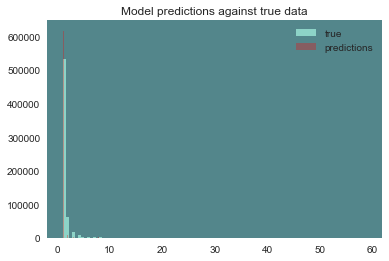

In [126]:
plt.title('Model predictions against true data')
s = pd.Series(y_hat.flatten())
y_true[y_true < 60].hist(bins = 100, label = 'true')
s[s < 60].hist(bins = 100, label = 'predictions', alpha = 0.3, color = 'red')
plt.legend()
plt.show()

In [127]:
user_list = pd.DataFrame({'user_id' : user_track['user_id'].unique()})
user_list['track_id'] = 1

In [128]:
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('User-Embedding-MLP').output)
intermediate_output = intermediate_layer_model.predict([user_list.user_id, user_list.track_id])

In [129]:
intermediate_output = intermediate_output.reshape(intermediate_output.shape[0], intermediate_output.shape[2])

In [130]:
for i in range(intermediate_output.shape[1]):
    user_list['vector_' + str(i+1)] = intermediate_output[:, i]

In [131]:
user_list['user_id'] = user_list['user_id'].map(user_dict_back)
user_list.drop('track_id', axis = 1, inplace = True)

In [132]:
user_list.head()

,user_id,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,-0.01,0.03,-0.02,0.02,-0.04,-0.02,-0.02,-0.04
1,0000cfa27c54f3a9c1bca6ec656a52926c52d234,0.02,-0.02,0.01,-0.04,0.05,-0.00,0.01,-0.01
2,00012873b0a82e81b3155431769fa5ac0a8ac267,-0.02,-0.00,0.03,0.02,-0.01,0.00,0.00,0.02
3,000134b94b87f70dc30597aa19598fbeaa70dc7f,-0.00,0.03,-0.01,-0.02,0.01,-0.02,-0.03,-0.03
4,00015babedef955867a39cd602388fe44b3d4362,0.01,0.01,0.01,0.03,0.01,0.04,-0.04,-0.04


# Print all users in 2d space

In [133]:
cols = [c for c in user_list.columns if 'vector' in c]

In [134]:
pca = PCA(n_components=2)
pca.fit(user_list[cols])

print(pca.explained_variance_ratio_.sum())  

0.26338946555221293


In [135]:
X_2d = pca.transform(user_list[cols])

pca_df  = pd.DataFrame({'PCA component 1' : X_2d[:, 0], 'PCA component 2' : X_2d[:, 1], 'user_id' : user_list['user_id']})
pca_df['suspicious'] = pca_df['user_id'].isin(users_suspicious)*1

pca_df['suspicious'] = pca_df['suspicious'].map({0 : 'not suspicious', 1 : 'suspicious'})

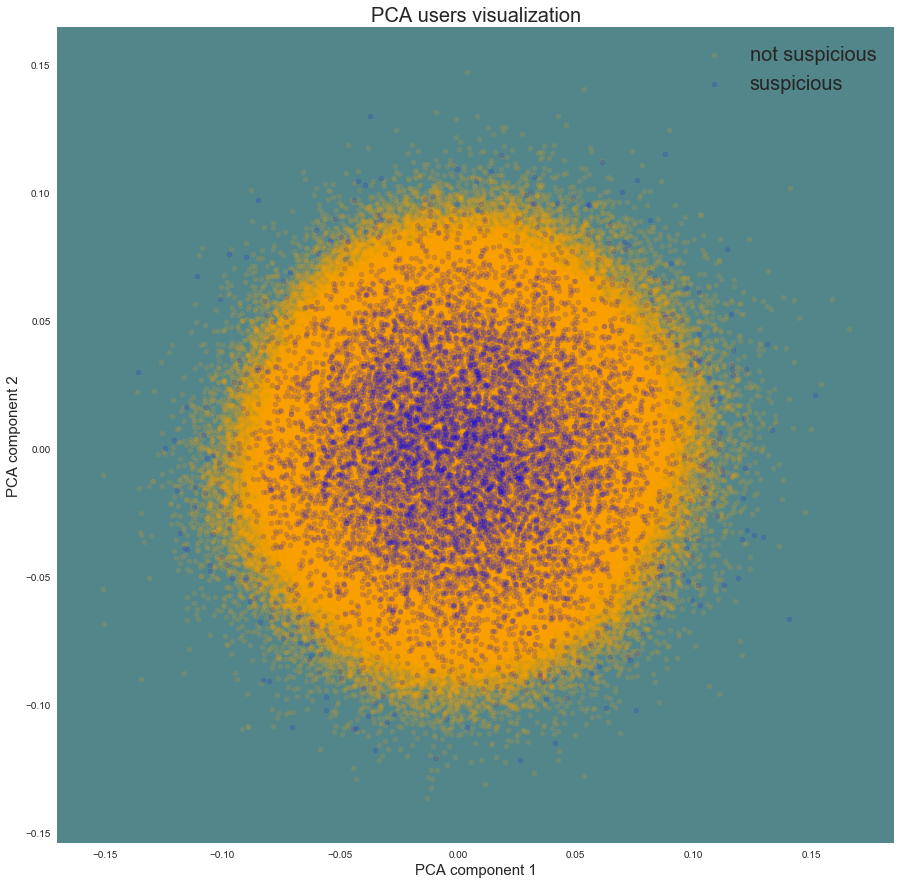

In [136]:
#Now we jsut plot a scatter plot
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PCA component 1', fontsize = 15)
ax.set_ylabel('PCA component 2', fontsize = 15)
ax.set_title('PCA users visualization', fontsize = 20)

targets = ['not suspicious', 'suspicious']
colors = ['orange', 'b']
for target, color in zip(targets,colors):

    indicesToKeep = pca_df['suspicious'] == target

    ax.scatter(pca_df.loc[indicesToKeep, 'PCA component 1']
               , pca_df.loc[indicesToKeep, 'PCA component 2']
               , c = color
               , s = 25,alpha=0.15)

ax.legend(targets, fontsize = 20)
ax.grid()

plt.show()

#### seems like indeed suspicious users have specific content

In [137]:
# # Try to clusterize users

# from sklearn.cluster import MeanShift

# kmeans = KMeans(n_clusters=20, random_state=0, n_jobs = -1).fit(user_list[cols])

# user_list['cluster'] = kmeans.labels_
# user_list['cluster'].value_counts()

# user_list['suspicious'] = user_list['user_id'].isin(users_suspicious)*1
# user_list[user_list['suspicious'] == 1]['cluster'].value_counts()

# For each user calculate his neighbors

In [346]:
# only_suspicious = user_list[user_list['user_id'].isin(allusers[allusers['outlier'] == 1]['user_id'].unique())]\
# .reset_index(drop = True)

In [419]:
# only_suspicious = user_list[user_list['user_id'].isin(users_suspicious)]\
# .reset_index(drop = True)

In [476]:
only_suspicious = allcountries[allcountries['user_id'].isin(allusers[allusers['outlier'] == 1]['user_id'].unique())]
only_suspicious = only_suspicious.groupby('user_id')['track_id'].apply(list).reset_index()

tv = TfidfVectorizer()
tv.fit([' '.join(ll for ll in l).strip() for l in only_suspicious['track_id'].values])

features_vec = tv.transform([' '.join(ll for ll in l).strip() for l in only_suspicious['track_id'].values])

In [477]:
# features_vec = only_suspicious.iloc[:, 1:].values

In [478]:
# # build the search index!
# cp = ci.MultiClusterIndex(features_vec, user_history)

In [479]:
features_vec.shape

(4841, 21238)

In [480]:
from sklearn.neighbors import LSHForest

In [481]:
lshf = LSHForest(random_state=42, n_candidates=100, n_estimators=10, n_neighbors=5,
     radius=0.1)
lshf.fit(features_vec)

LSHForest(min_hash_match=4, n_candidates=100, n_estimators=10, n_neighbors=5,
     radius=0.1, radius_cutoff_ratio=0.9, random_state=42)

In [490]:
# %%timeit -r1 -n1
distances = lshf.radius_neighbors(features_vec, radius = 0.01)

In [491]:
index_match = only_suspicious.set_index(only_suspicious.index)['user_id'].to_dict()

In [492]:
neigbors = []

counter = 0
for d in distances[1]:
    if len(d) > 1:
        n = []
        for ii in d[1:]:
            n.append(index_match[ii])
        neigbors.append(n) 
        counter += 1
    else:
        neigbors.append([])

In [493]:
# neigbors = []

# counter = 0
# for i, d in zip(indices, distances):
#     if i[np.logical_and(d > 0.001, d < 0.01)].shape[0] > 0:
#         n = []
#         for ii in i[np.logical_and(d > 0.001, d < 0.01)]:
#             n.append(index_match[ii])
#         neigbors.append(n) 
#         counter += 1
#     else:
#         neigbors.append([])

In [494]:
only_suspicious['possible_duplicate_accounts'] = neigbors

In [495]:
only_suspicious['n_duplicates'] = only_suspicious['possible_duplicate_accounts'].map(lambda x: len(x))

In [496]:
only_suspicious['n_duplicates'].mean()

2.0095021689733525

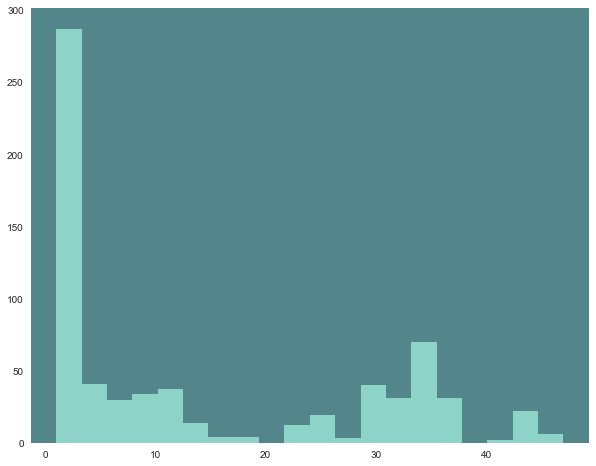

In [506]:
only_suspicious[only_suspicious['n_duplicates'] > 0]['n_duplicates'].hist(bins = 20)
plt.show()

In [499]:
only_suspicious[only_suspicious['n_duplicates'] > 0].shape[0]

687

In [500]:
only_suspicious[only_suspicious['n_duplicates'] > 0].shape[0] / allcountries['user_id'].nunique()

0.00038428062890014076

In [501]:
len(set(allcountries[allcountries['user_id'] == '008b39ca99a36bd1eed3df13f733767450ae9230']['track_id'].unique()) & \
set(allcountries[allcountries['user_id'] == 'b0e12af6bf1ee8b10a78f7797e4d5f6a154bf1fa']['track_id'].unique())) / len(set(allcountries[allcountries['user_id'] == '008b39ca99a36bd1eed3df13f733767450ae9230']['track_id'].unique()))

1.0

# <b style = "color:blue;font-size:30px">STEP 3: FRAUD MODEL</b>

# Create features for each user in one place